<h1> TENSORFLOW MACHINE LEARNING </h1>

In [2]:
# CORE ALGORITHMS

# importing modules
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

# load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

2024-01-03 21:21:51.623934: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-03 21:21:51.765296: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-03 21:21:51.765351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-03 21:21:51.784790: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-03 21:21:51.846774: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-03 21:21:51.847940: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
# showing the first 5 rows
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [4]:
# training the feature columns

CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)) # associate every feature name with a list of unique vocabulary

for feature_name in NUMERIC_COLUMNS: 
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32)) # for the ones with numerical features


# print it
print(feature_columns)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', 

In [5]:
# The training process - Input Function
def make_input_fn(data_df, label_df, num_epochs = 10, shuffle = True, batch_size = 32):
    def input_function(): # inner function, this will be returned
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) # creates dataset object with data and its features
        if shuffle:
            ds = ds.shuffle(1000) # randomize the data
        ds = ds.batch(batch_size).repeat(num_epochs) # split dataset into baches of 32 and repeat the process of num of epochs
        return ds # return the batch dataset
    return input_function # return a function to use

train_input_fn = make_input_fn(dftrain, y_train) # get a dataset to train
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs = 1, shuffle = False) # for testing

In [6]:
# Creating the model
linear_est = tf.estimator.LinearClassifier(feature_columns = feature_columns)

# Training the model
linear_est.train(train_input_fn) # train the model
result = linear_est.evaluate(eval_input_fn) # testing the model
clear_output() # clear the console for useless training outputs
print(result['accuracy']) # see the accuracy

0.7348485


In [7]:
# dictionary of one prediction
print(dfeval.loc[0]) # print the person
# print(result[0]['probabilities'][1]) # change of survival: index 1

sex                          male
age                          35.0
n_siblings_spouses              0
parch                           0
fare                         8.05
class                       Third
deck                      unknown
embark_town           Southampton
alone                           y
Name: 0, dtype: object


In [8]:
# print(result[0]['probabilities'][0]) # change of not survival: index 0

In [9]:
print(y_eval.loc[0]) # if they survive or not

0


In [10]:
# Classification

CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']
# Lets define some constants to help us later on

train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)
# Here we use keras (a module inside of TensorFlow) to grab our datasets and read them into a pandas dataframe

In [11]:
# see the data
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


In [12]:
# remove the species column and use that as our label
train_y = train.pop('Species')
test_y = test.pop('Species')
train.head() # the species column is gone

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


In [13]:
train_y.head() # species stored in train_y 

0    2
1    1
2    2
3    0
4    0
Name: Species, dtype: int64

In [14]:
# shape of our train model
train.shape

(120, 4)

In [15]:
# Input Function
def input_fn(features, labels, training = True, batch_size = 256):
    # converts the inputs to a Dataset
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # shuffle (random) and repeat 
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)

In [16]:
# Feature Columns
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key = key))
print(my_feature_columns)

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


In [17]:
# Building the Model

# build a DNN with 2 hidden layers (30 and 10 hidden nodes each)
classifier = tf.estimator.DNNClassifier(feature_columns = my_feature_columns, hidden_units = [30, 10], n_classes = 3)

Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp8rfiio4q', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_work

In [18]:
# Training the Model
classifier.train(
    input_fn = lambda: input_fn(train, train_y, training = True), steps = 5000
)

Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp8rfiio4q/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


2024-01-03 21:21:57.827478: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT64
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'dnn/zero_fraction/cond/output/_18'


INFO:tensorflow:loss = 2.5361938, step = 0
INFO:tensorflow:global_step/sec: 388.961
INFO:tensorflow:loss = 1.5457482, step = 100 (0.258 sec)
INFO:tensorflow:global_step/sec: 429.568
INFO:tensorflow:loss = 1.3309132, step = 200 (0.233 sec)
INFO:tensorflow:global_step/sec: 434.291
INFO:tensorflow:loss = 1.160214, step = 300 (0.230 sec)
INFO:tensorflow:global_step/sec: 434.323
INFO:tensorflow:loss = 1.0382478, step = 400 (0.230 sec)
INFO:tensorflow:global_step/sec: 408.085
INFO:tensorflow:loss = 0.9866899, step = 500 (0.245 sec)
INFO:tensorflow:global_step/sec: 437.331
INFO:tensorflow:loss = 0.95872295, step = 600 (0.229 sec)
INFO:tensorflow:global_step/sec: 437.998
INFO:tensorflow:loss = 0.9498472, step = 700 (0.228 sec)
INFO:tensorflow:global_step/sec: 438.042
INFO:tensorflow:loss = 0.92402244, step = 800 (0.228 sec)
INFO:tensorflow:global_step/sec: 416.026
INFO:tensorflow:loss = 0.88563025, step = 900 (0.240 sec)
INFO:tensorflow:global_step/sec: 436.752
INFO:tensorflow:loss = 0.8639361

In [19]:
# Testing the Model

eval_result = classifier.evaluate(input_fn = lambda: input_fn(test, test_y, training = False))
print('\nTest set accuracy: {accuracy: 0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2024-01-03T21:22:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp8rfiio4q/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.12711s
INFO:tensorflow:Finished evaluation at 2024-01-03-21:22:10
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.53333336, average_loss = 0.6977308, global_step = 5000, loss = 0.6977308
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmp8rfiio4q/model.ckpt-5000

Test set accuracy:  0.533



In [20]:
# Predictions

def input_fn(features, batch_size=256):
    # convert the inputs to a Dataset without labels
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
predict = {}

print("Please type numeric values as prompted.")
for feature in features:
  valid = True
  while valid: 
    val = input(feature + ": ")
    if not val.isdigit(): valid = False

  predict[feature] = [float(val)]

predictions = classifier.predict(input_fn=lambda: input_fn(predict))
for pred_dict in predictions:
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]

    print('Prediction is "{}" ({:.1f}%)'.format(
        SPECIES[class_id], 100 * probability))


Please type numeric values as prompted.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp8rfiio4q/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction is "Virginica" (50.0%)


In [21]:
# Clustering & K-Means

# probability hot and cold day / weather model 
import tensorflow_probability as tfp
import tensorflow as tf

tfd = tfp.distributions # shortcut
initial_distribution = tfd.Categorical(probs=[0.8, 0.2]) #  first day has 80% of being cold and 20% of being hot
transition_distribution = tfd.Categorical(probs=[[0.7, 0.3], [0.2, 0.8]]) # a cold day has 30% change of being followed by a hot day (70% change of being cold)
                                                                         # a hot day has a 20% chance of being followed by a cold day (80% change of being hot)
observation_distribution = tfd.Normal(loc=[0., 15.], scale=[5., 10.]) # loc = mean and standard deviation (average temperature is 15 and ranges from 5 to 25)

In [22]:
# create the hidden markov model
model = tfd.HiddenMarkovModel(
    initial_distribution = initial_distribution,
    transition_distribution = transition_distribution,
    observation_distribution = observation_distribution,
    num_steps = 7 # how many days we want to predict for
)

In [23]:
# to get the expected temperatures on each day
mean = model.mean() # calculate the probabilities

with tf.compat.v1.Session() as sess:
    print(mean.numpy())

[3.        5.9999995 7.4999995 8.25      8.625001  8.812501  8.90625  ]


In [24]:
# Neural Networks
from tensorflow import keras

# dataset includes 60.000 images for training and 10.000 images for testing
fashion_mnist = keras.datasets.fashion_mnist # load dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data() # split into testing and training

In [25]:
# shape of dataset
train_images.shape # 60.000 images and images of 28x28 pixels (784 in total) 28 rows and 28 columns

(60000, 28, 28)

In [26]:
type(train_images) # type of data

numpy.ndarray

In [27]:
train_images[0, 23, 23] # show one pixel (image zero, row 23, columns 23)
# 0 for black and 255 for white

194

In [28]:
print(train_images) # multiple pixels

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [29]:
train_labels[:10] # 10 different classes for dataset / each integer represents a speicific article of clothing

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

In [30]:
# create an array of label names to indicate which is which
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

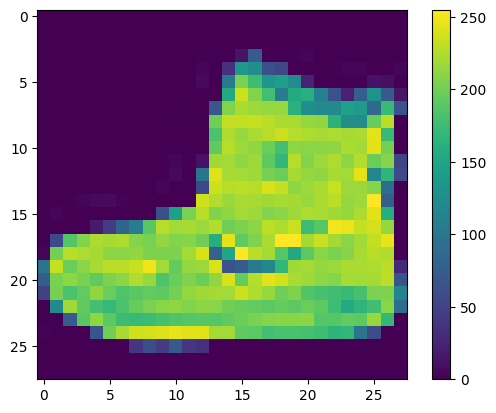

In [31]:
# what the images look like (10 examples)
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

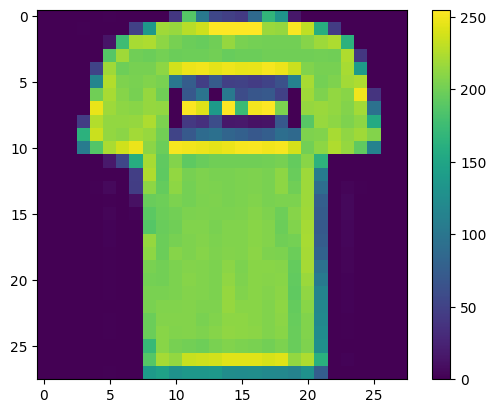

In [32]:
plt.figure()
plt.imshow(train_images[1])
plt.colorbar()
plt.grid(False)
plt.show()

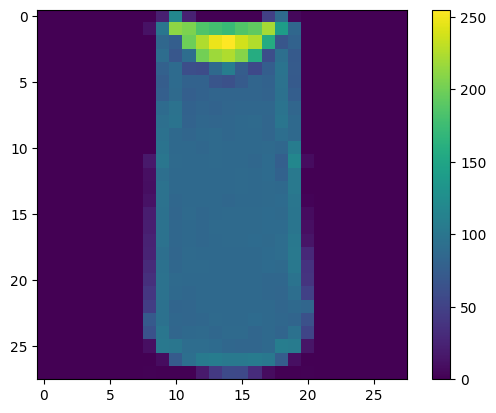

In [33]:
plt.figure()
plt.imshow(train_images[2])
plt.colorbar()
plt.grid(False)
plt.show()

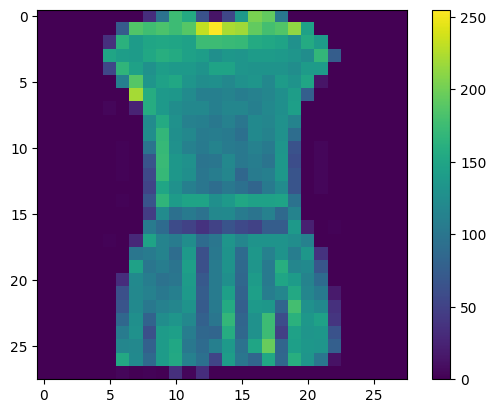

In [34]:
plt.figure()
plt.imshow(train_images[3])
plt.colorbar()
plt.grid(False)
plt.show()

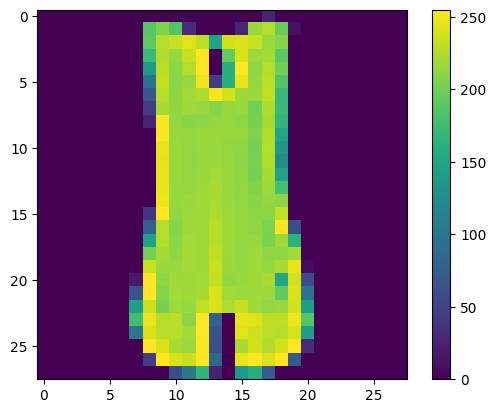

In [35]:
plt.figure()
plt.imshow(train_images[4])
plt.colorbar()
plt.grid(False)
plt.show()

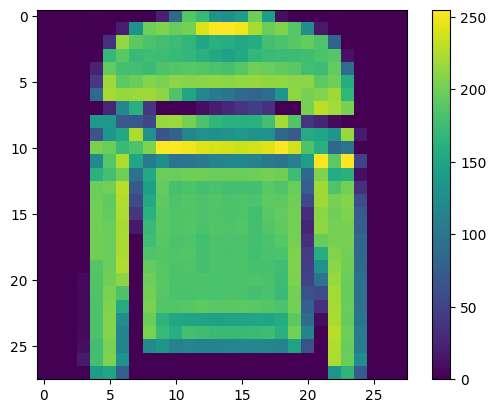

In [36]:
plt.figure()
plt.imshow(train_images[5])
plt.colorbar()
plt.grid(False)
plt.show()

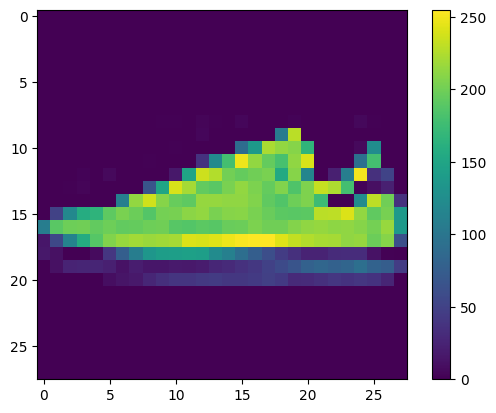

In [37]:
plt.figure()
plt.imshow(train_images[6])
plt.colorbar()
plt.grid(False)
plt.show()

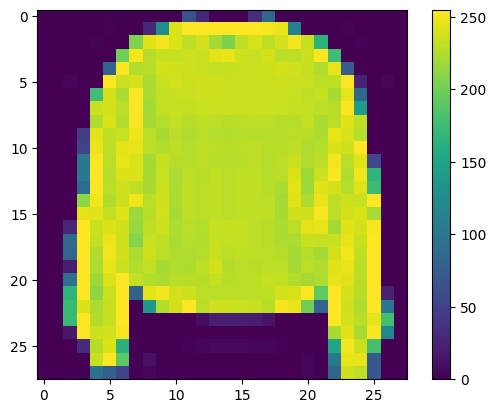

In [38]:
plt.figure()
plt.imshow(train_images[7])
plt.colorbar()
plt.grid(False)
plt.show()

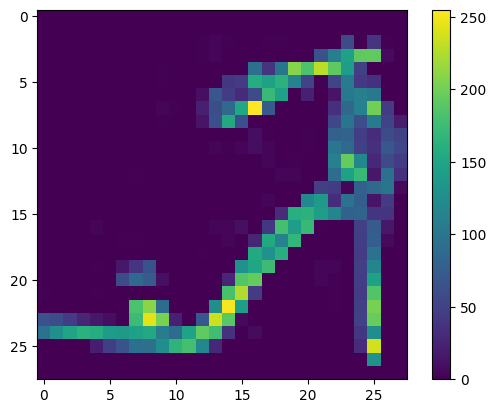

In [39]:
plt.figure()
plt.imshow(train_images[8])
plt.colorbar()
plt.grid(False)
plt.show()

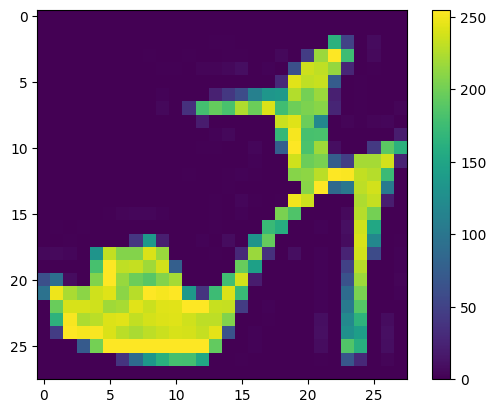

In [40]:
plt.figure()
plt.imshow(train_images[9])
plt.colorbar()
plt.grid(False)
plt.show()

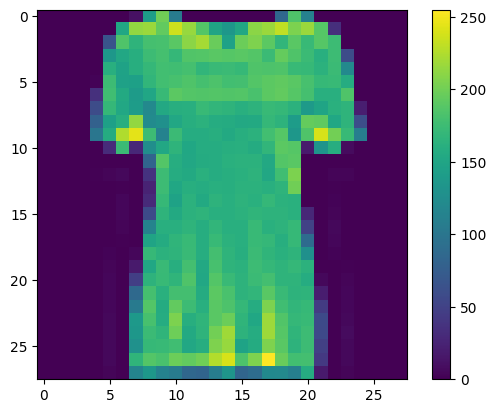

In [41]:
plt.figure()
plt.imshow(train_images[10])
plt.colorbar()
plt.grid(False)
plt.show()

In [42]:
# Data Preprocessing

# squish all the values from 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

In [43]:
# Creating the Model

model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)), # input layer 1 => 784 pixels
    #dense (all the neurons from previous layer are connected to every neuron in this layer)
    keras.layers.Dense(128, activation = 'relu'), # hidden layer 2 => rectified linear unit (relu)
    keras.layers.Dense(10, activation = 'softmax') # output layer 3 => 10 classes to predict for
])

In [44]:
# Compile the Model

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']) # algorithm performs the gradient descent

In [45]:
# Training the Model

model.fit(train_images, train_labels, epochs = 10) # epochs is a hyperparamter

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4992 - accuracy: 0.8246
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3713 - accuracy: 0.8654
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3360 - accuracy: 0.8770
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3107 - accuracy: 0.8864
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2946 - accuracy: 0.8917
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2793 - accuracy: 0.8967
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2666 - accuracy: 0.9022
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2566 - accuracy: 0.9050
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2480 - accuracy: 0.9071
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.239

In [46]:
# Testing the Model

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose = 1) # verbose (how much is printing out to the console)

print('Test accuracy:', test_acc) # overfitting (memorize the data)

313/313 [==============================] - 0s 837us/step - loss: 0.3360 - accuracy: 0.8838
Test accuracy: 0.8838000297546387


In [47]:
# Making Predictions

predictions = model.predict(test_images) # all the test images
print(predictions)

313/313 [==============================] - 0s 599us/step
[[7.09961938e-08 2.09006212e-09 2.11453170e-07 ... 5.82993357e-03
  1.49048844e-07 9.90142524e-01]
 [9.94779020e-06 2.03764872e-15 9.99871016e-01 ... 5.18603799e-15
  2.48139287e-11 2.19009788e-14]
 [8.43826564e-10 9.99999940e-01 1.13861394e-12 ... 1.40209830e-24
  3.61400077e-10 5.65031910e-23]
 ...
 [1.16141855e-04 1.62399989e-11 3.40633346e-06 ... 1.14812226e-09
  9.99822855e-01 5.70211033e-13]
 [6.47380460e-08 9.99863386e-01 1.73263026e-09 ... 2.74021998e-15
  3.50886786e-08 1.67444421e-14]
 [1.47739947e-05 9.46214307e-09 3.50085684e-05 ... 5.63142169e-03
  4.53411281e-04 1.71549746e-05]]


In [48]:
test_images.shape # array of 10.000 entries

(10000, 28, 28)

In [49]:
print(predictions[0]) # prediction 0

[7.0996194e-08 2.0900621e-09 2.1145317e-07 5.1591633e-07 3.7944670e-08
 4.0264572e-03 1.0172587e-07 5.8299336e-03 1.4904884e-07 9.9014252e-01]


In [50]:
print(np.argmax(predictions[0])) # prediction for a class

9


Ankle boot


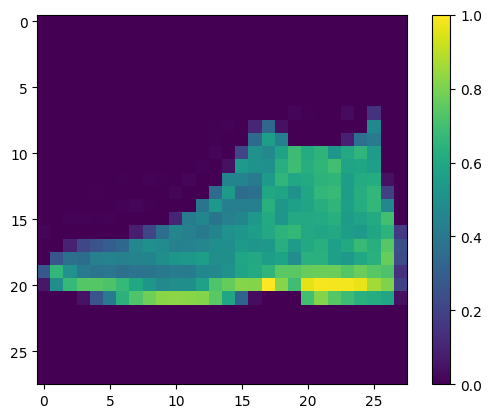

In [51]:
print(class_names[np.argmax(predictions[0])]) # prediction for a class

# show the image
plt.figure()
plt.imshow(test_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Pullover


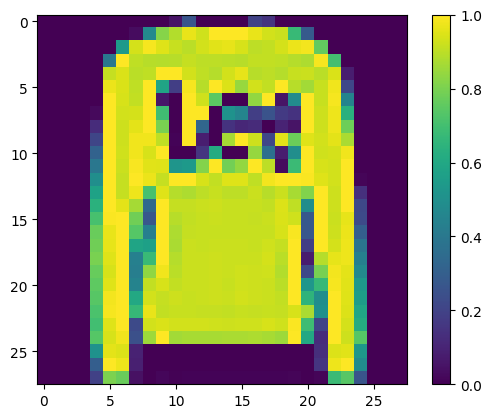

In [52]:
print(class_names[np.argmax(predictions[1])]) # prediction for a class

# show the image
plt.figure()
plt.imshow(test_images[1])
plt.colorbar()
plt.grid(False)
plt.show()

Trouser


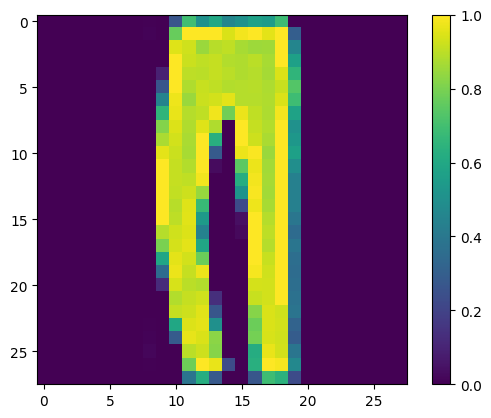

In [53]:
print(class_names[np.argmax(predictions[2])]) # prediction for a class

# show the image
plt.figure()
plt.imshow(test_images[2])
plt.colorbar()
plt.grid(False)
plt.show()

1/1 [==============================] - 0s 12ms/step


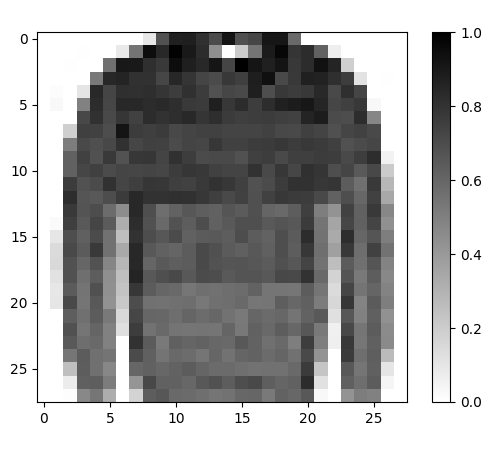

In [54]:
# type a number and show the image, expected and guess the clothes
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR

def predict(model, image, correct_label):
  class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  prediction = model.predict(np.array([image]))
  predicted_class = class_names[np.argmax(prediction)]

  show_image(image, class_names[correct_label], predicted_class)


def show_image(img, label, guess):
  plt.figure()
  plt.imshow(img, cmap=plt.cm.binary)
  plt.title("Excpected: " + label)
  plt.xlabel("Guess: " + guess)
  plt.colorbar()
  plt.grid(False)
  plt.show()


def get_number():
  while True:
    num = input("Pick a number: ")
    if num.isdigit():
      num = int(num)
      if 0 <= num <= 1000:
        return int(num)
    else:
      print("Try again...")

num = get_number()
image = test_images[num]
label = test_labels[num]
predict(model, image, label)


In [55]:
# Deep Computer Vision

# Convolutional Neural Network

# CIFAR Image Dataset (60.000 images with 32x32 color images with 6000 images of each class)

# importing
from tensorflow.keras import datasets, layers, models 

# load the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

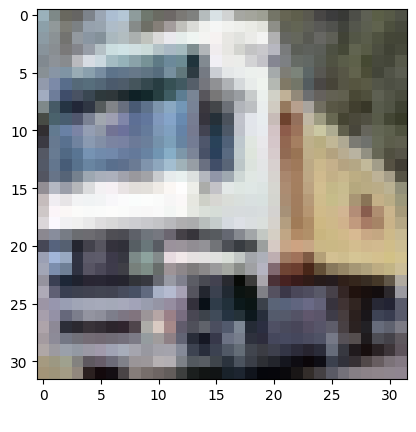

In [56]:
# look over images
IMG_INDEX = 1

plt.imshow(train_images[IMG_INDEX], cmap = plt.cm.binary)
plt.xlabel(class_names[train_labels[IMG_INDEX][0]])
plt.show()

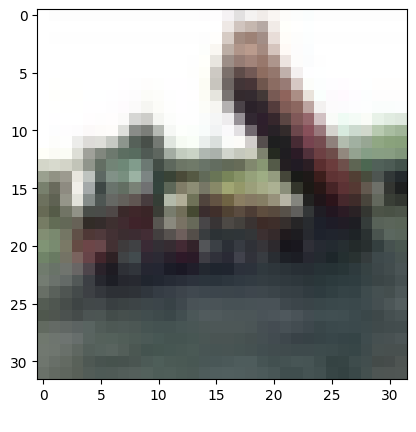

In [57]:
IMG_INDEX = 2

plt.imshow(train_images[IMG_INDEX], cmap = plt.cm.binary)
plt.xlabel(class_names[train_labels[IMG_INDEX][0]])
plt.show()

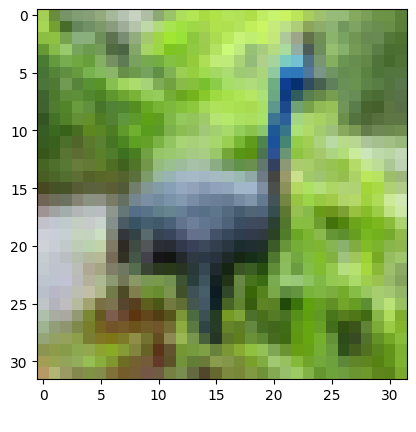

In [58]:
IMG_INDEX = 6

plt.imshow(train_images[IMG_INDEX], cmap = plt.cm.binary)
plt.xlabel(class_names[train_labels[IMG_INDEX][0]])
plt.show()

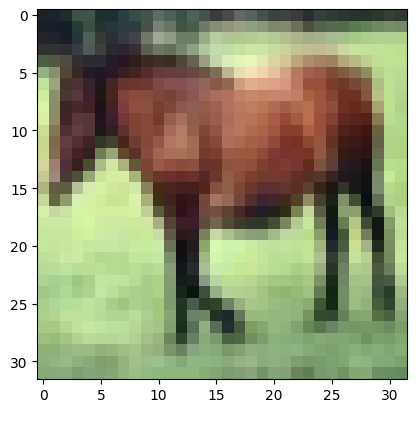

In [59]:
IMG_INDEX = 7

plt.imshow(train_images[IMG_INDEX], cmap = plt.cm.binary)
plt.xlabel(class_names[train_labels[IMG_INDEX][0]])
plt.show()

In [60]:
# CNN Arhitecture (define the layers)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3))) # input data will be 32x32 pixels and process 32 filters
model.add(layers.MaxPooling2D((2, 2))) # max pooling operation using 2x2 samples and stride of 2
# take as input the feature map from the previous layer, increase frequency of filters from 32 to 64
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [61]:
# look at the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56320 (220.00 KB)
Trainable params: 5632

In [62]:
# adding dense layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(10)) # 10 neurons (one for each class)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 1024)             

_________________________________________________________________


In [63]:
# Training
model.compile(optimizer = 'adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])

history = model.fit(train_images, train_labels, epochs = 10, validation_data = (test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 16s 10ms/step - loss: 1.5173 - accuracy: 0.4461 - val_loss: 1.2536 - val_accuracy: 0.5461
Epoch 2/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.1679 - accuracy: 0.5853 - val_loss: 1.1492 - val_accuracy: 0.5947
Epoch 3/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.0201 - accuracy: 0.6426 - val_loss: 1.0236 - val_accuracy: 0.6365
Epoch 4/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.9254 - accuracy: 0.6760 - val_loss: 0.9691 - val_accuracy: 0.6588
Epoch 5/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.8588 - accuracy: 0.6984 - val_loss: 0.8940 - val_accuracy: 0.6885
Epoch 6/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.7939 - accuracy: 0.7223 - val_loss: 0.8881 - val_accuracy: 0.6897
Epoch 7/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.7462 - accuracy: 0.7390 - val_loss: 0.8970 - val_

In [65]:
# Evaluate the model

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose = 2)
print(test_acc)

313/313 - 1s - loss: 0.8563 - accuracy: 0.7052 - 728ms/epoch - 2ms/step
0.7052000164985657


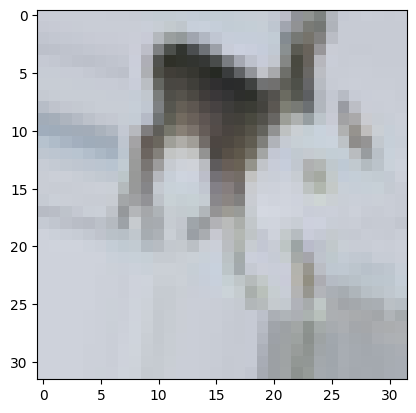

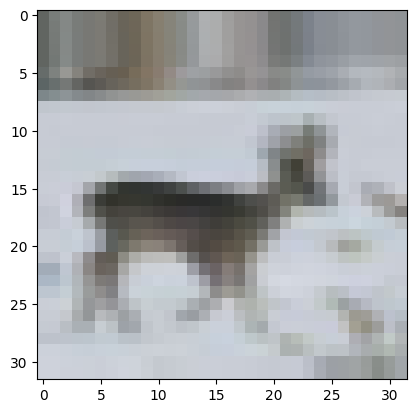

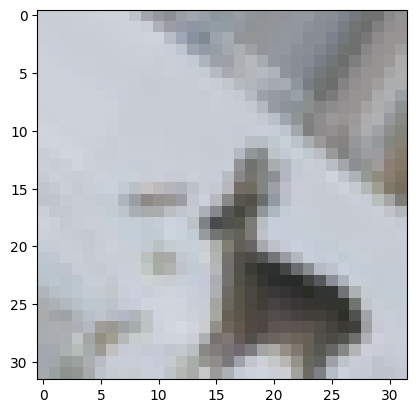

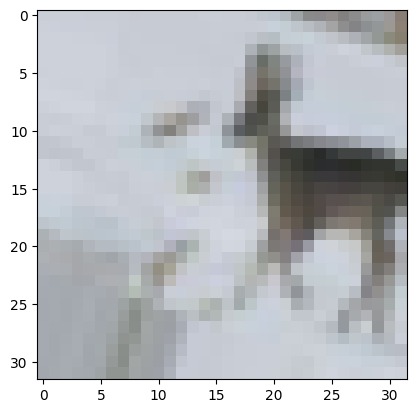

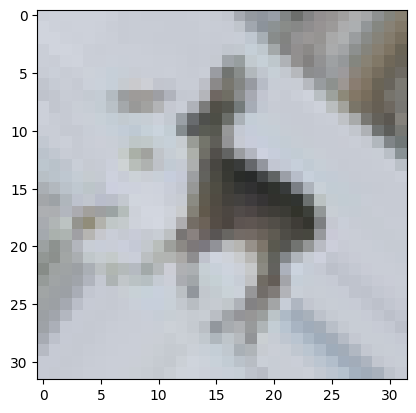

In [66]:
# Working with Small Datasets

# Data Augmentation
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# creates a data generator object that transforms images
datagen = ImageDataGenerator(
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

# pick an image to transform
test_img = train_images[20]
img = image.img_to_array(test_img)  # convert image to numpy arry
img = img.reshape((1,) + img.shape)  # reshape image

i = 0

for batch in datagen.flow(img, save_prefix='test', save_format='jpeg'):  # this loops runs forever until we break, saving images to current directory with specified prefix
    plt.figure(i)
    plot = plt.imshow(image.img_to_array(batch[0]))
    i += 1
    if i > 4:  # show 4 images
        break

plt.show()


In [73]:
# Pretrained Models

import os

# Dataset
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# split the data manually into 80% training, 10% testing, 10% validation
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

/home/marius/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-03 21:38:53.432369: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


Dataset cats_vs_dogs downloaded and prepared to /home/marius/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


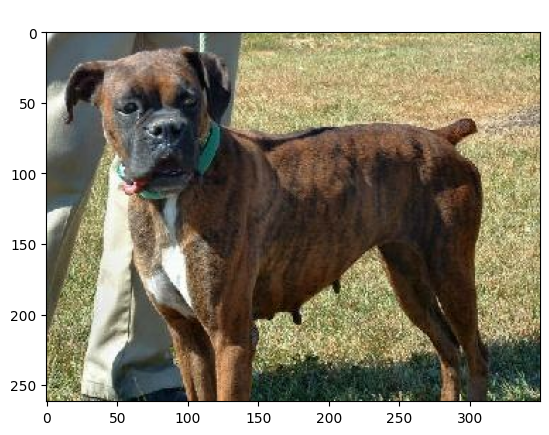

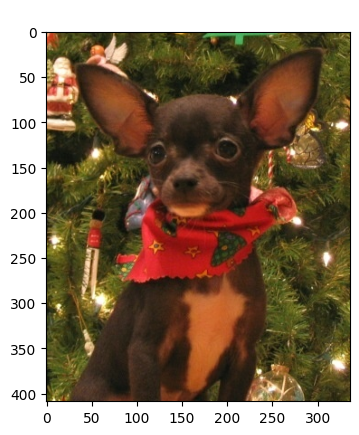

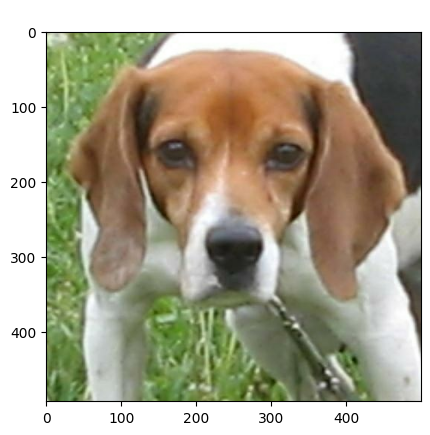

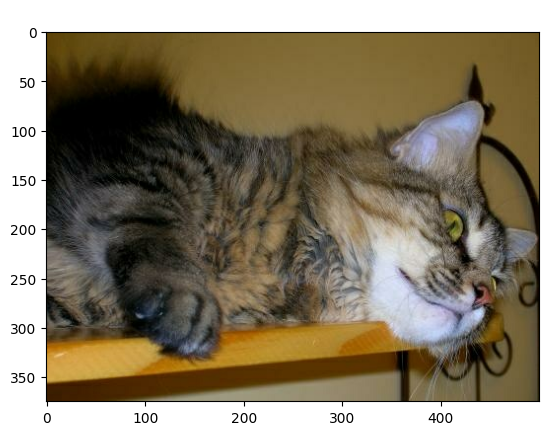

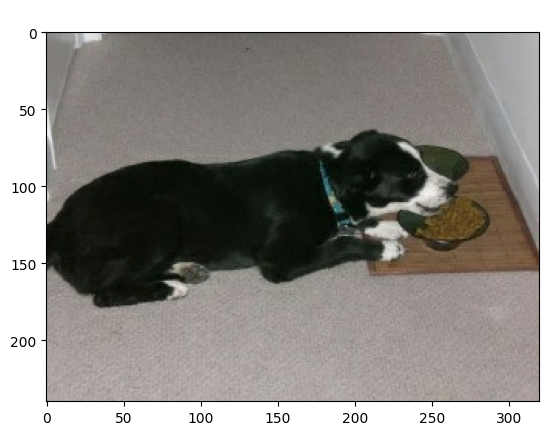

In [74]:
get_label_name = metadata.features['label'].int2str  # creates a function object that we can use to get labels

# display 2 images from the dataset
for image, label in raw_train.take(5):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [75]:
# Dat Processing

IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  """
  returns an image that is reshaped to IMG_SIZE
  """
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [76]:
# apply this function to all our images 
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

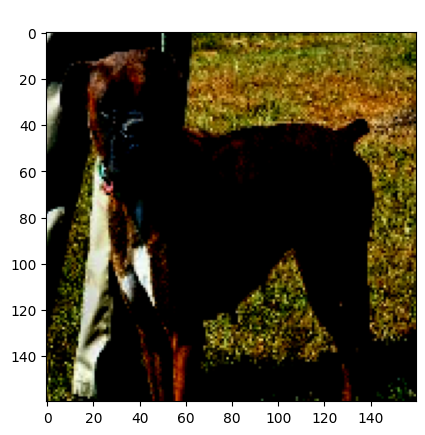

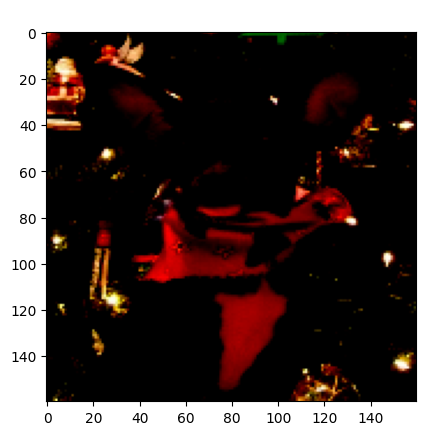

In [77]:
# show the images
for image, label in train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [78]:
# suffle amd batch the images
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [79]:
# original image vs the new image
for img, label in raw_train.take(2):
  print("Original shape:", img.shape)

for img, label in train.take(2):
  print("New shape:", img.shape)

Original shape: (262, 350, 3)
Original shape: (409, 336, 3)
New shape: (160, 160, 3)
New shape: (160, 160, 3)


In [80]:
# Picking a Pretrained Model

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [81]:
# summary
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [82]:
for image, _ in train_batches.take(1): # 32 pixels
   pass

feature_batch = base_model(image)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [85]:
# Freezing the Base

base_model.trainable = False # to not train the model (trainable params: 0)

base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [87]:
# Adding our Classifier
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # take the entire average of each single different layers

prediction_layer = keras.layers.Dense(1) # prediction layer

In [88]:
# combined them into a model
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [89]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [91]:
# Training the Model

base_learning_rate = 0.0001 # how much i am allowed to modify the length of biases
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [92]:
# We can evaluate the model right now to see how it does before training it on our new images

initial_epochs = 3
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 5s 189ms/step - loss: 0.8740 - accuracy: 0.4125


In [93]:
# Now we can train it on our images

history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

acc = history.history['accuracy']
print(acc)

Epoch 1/3
582/582 [==============================] - 139s 234ms/step - loss: 0.2223 - accuracy: 0.9025 - val_loss: 0.0882 - val_accuracy: 0.9716
Epoch 2/3
582/582 [==============================] - 154s 263ms/step - loss: 0.0725 - accuracy: 0.9736 - val_loss: 0.0665 - val_accuracy: 0.9772
Epoch 3/3
582/582 [==============================] - 131s 223ms/step - loss: 0.0589 - accuracy: 0.9782 - val_loss: 0.0595 - val_accuracy: 0.9798
[0.9024717807769775, 0.9735625982284546, 0.978237509727478]
